In [1]:
import os
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Settings
root_dir = "Background"
screen_states = ["screen on", "screen off"]
repeats = ["repeat 1", "repeat 2", "repeat 3"]
ns_values = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
txtdata = ["counts", "timestamps", "timestamps_channel"]

In [2]:
def getData():
    # Initialize deeply nested defaultdict
    def nested_dict():
        return defaultdict(nested_dict)

    data = nested_dict()

    # Read the files
    for screen_state in screen_states:
        for repeat in repeats:
            for ns in ns_values:
                filename = f"coincWin_{ns}ns.txt"
                file_path = os.path.join(root_dir, screen_state, repeat, filename)

                try:
                    with open(file_path, "r") as f:
                        for line, dat in zip(f, txtdata):
                            data[screen_state][repeat][ns][dat] = np.array([int(x.strip()) for x in line.strip().strip("[]").split(",")])
                except FileNotFoundError:
                    print(f"Missing: {file_path}")
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    return data

data = getData()

In [3]:
screenoff_countdata_1 = np.vstack(tuple(data["screen off"]["repeat 1"][ns]["counts"] for ns in ns_values))
screenoff_countdata_2 = np.vstack(tuple(data["screen off"]["repeat 2"][ns]["counts"] for ns in ns_values))
screenoff_countdata_3 = np.vstack(tuple(data["screen off"]["repeat 3"][ns]["counts"] for ns in ns_values))
screenon_countdata_1 = np.vstack(tuple(data["screen on"]["repeat 1"][ns]["counts"] for ns in ns_values))
screenon_countdata_2 = np.vstack(tuple(data["screen on"]["repeat 2"][ns]["counts"] for ns in ns_values))
screenon_countdata_3 = np.vstack(tuple(data["screen on"]["repeat 3"][ns]["counts"] for ns in ns_values))


colors = ["firebrick", "sandybrown", "gold", "yellowgreen", "greenyellow", "limegreen", "turquoise", "deepskyblue", "royalblue", "mediumorchid", "hotpink"]
CoincCounter_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32','1/2','1/3','2/3','1/4','2/4','3/4','1/5','2/5','3/5','4/5','1/2/3','1/2/4','1/3/4','2/3/4','1/2/5','1/3/5','2/3/5','1/4/5','2/4/5','3/4/5','1/2/3/4','1/2/3/5','1/2/4/5','1/3/4/5','2/3/4/5','1/2/3/4/5']

The following graphs technically have different coincidence windows, but that shouldn't affect the total count

Screen on data:

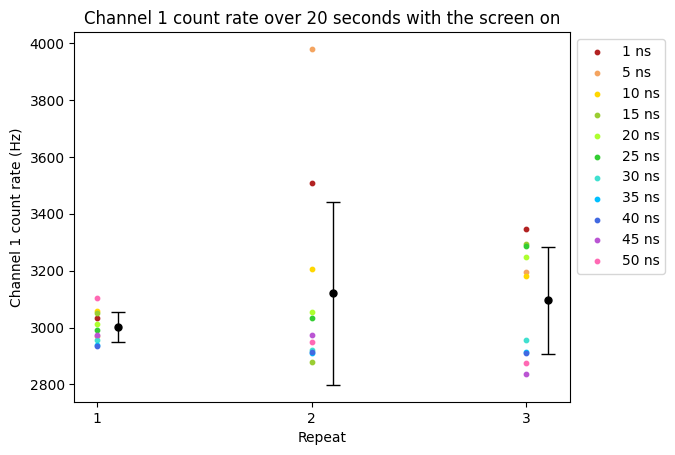

Average of the means: 3072.6242424242423 +- 29.446941150622788 Hz
Average stdev: 186.7700421691383 Hz


In [4]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenon_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenon_countdata_2[i,1]/20, color=colors[i], s=10)
    plt.scatter(3, screenon_countdata_3[i,1]/20, color=colors[i], s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenon_countdata_1[:,1]/20), np.mean(screenon_countdata_2[:,1]/20), np.mean(screenon_countdata_3[:,1]/20)])
stdevs = np.array([np.std(screenon_countdata_1[:,1]/20), np.std(screenon_countdata_2[:,1]/20), np.std(screenon_countdata_3[:,1]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen on")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

Some weird spread in repeat 2, perhaps due to opening and closing different coloured tabs on the computer. Also note that we were moving around and causing reflections

Screen off data:

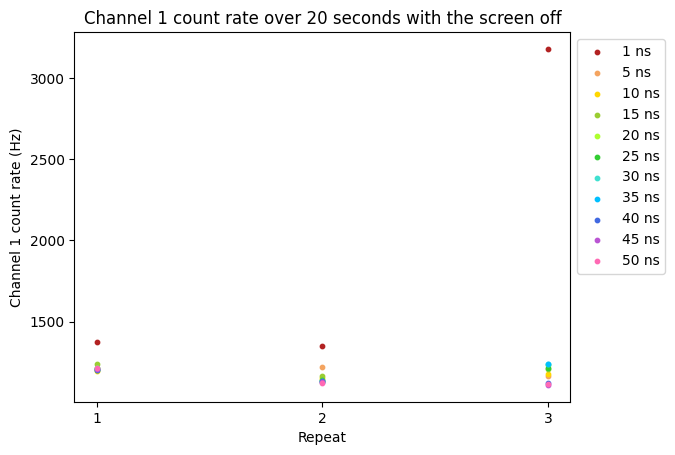

In [5]:
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenoff_countdata_2[i,1]/20, color=colors[i], s=10)
    plt.scatter(3, screenoff_countdata_3[i,1]/20, color=colors[i], s=10)
plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Weird anomaly in the 3rd repeat, possibly due to some accidental lighting from a phone or watch??? It aligns with the count rates we see with the screen on setting, so its likely something as intense as the screen was on for enough time

Looking at that anomalous plot (estimating the countrate over windows of 0.1 s):

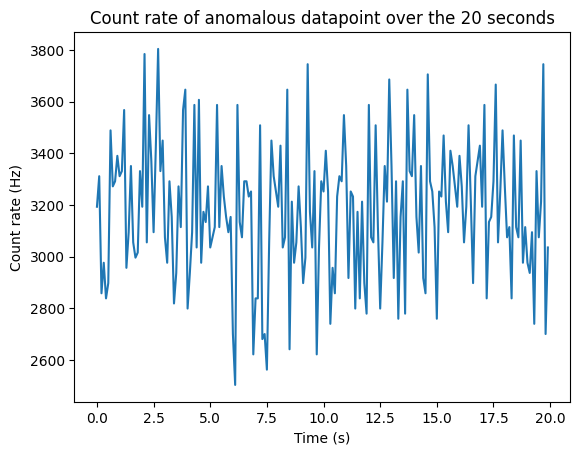

In [6]:
ch1_timestamps = []
for channel, timestamp in zip(data["screen off"]["repeat 3"][1]["timestamps_channel"], data["screen off"]["repeat 3"][1]["timestamps"]):
    if channel == 1:
        ch1_timestamps.append(timestamp)
ch1_timestamps = np.array(ch1_timestamps)

# Guess initial t0 from minimum timestamp data
t0 = data["screen off"]["repeat 3"][1]["timestamps"].min()
times_sec = (ch1_timestamps - t0) / 1e12

# Define bin edges for 0.1s bins
bin_width = 0.1  # seconds
max_time = times_sec.max()
bins = np.arange(0, max_time + bin_width, bin_width)

# Histogram counts in each bin
counts, bin_edges = np.histogram(times_sec, bins=bins)

# The timestamps have a buffer so they likely missed some counts that were measured
# Normalise to total counts and plot
plt.plot(bins[:-2], 10*counts[:-1]/(len(ch1_timestamps)/screenoff_countdata_3[0,1]))
plt.title("Count rate of anomalous datapoint over the 20 seconds")
plt.xlabel("Time (s)")
plt.ylabel("Count rate (Hz)")
plt.show()

Something was continuously screwing with our data that entire dataset. However we can afford to throw it away since we have 32 other datasets that roughly agree

Redoing the screen off graph neglecting the anomaly:

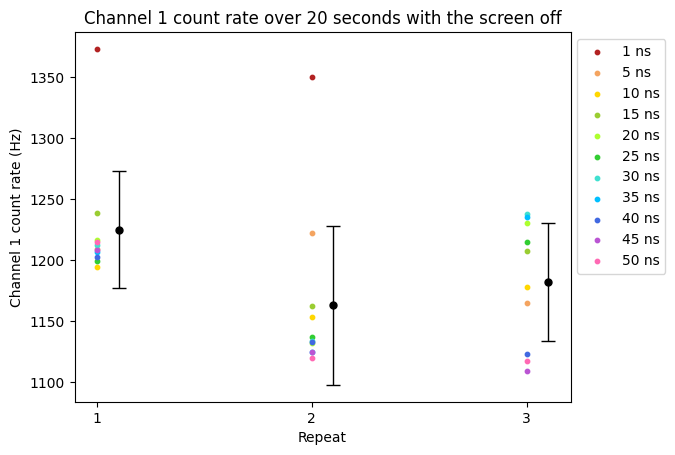

Average of the means: 1190.0525757575758 +- 14.978002658955221 Hz
Average stdev: 53.82688665599707 Hz


In [7]:
# Remove anomaly
new_screenoff_countdata_3 = screenoff_countdata_3[1:,1]

# PLot data
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,1]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenoff_countdata_2[i,1]/20, color=colors[i], s=10)
    if i != 0:
        plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=colors[i], s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenoff_countdata_1[:,1]/20), np.mean(screenoff_countdata_2[:,1]/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(screenoff_countdata_1[:,1]/20), np.std(screenoff_countdata_2[:,1]/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

There seems to be a consistent problem with the 1ns dataset in each dataset so far. I reckon it could be due to less counts being considered coincidences, boosting individual channel counts. We will most likely not be using 1ns coincidence window, so I will omit it from further datasets if I see it be anomalous. This is most prominent in screen off datasets where there is less noise, in screen on datasets I believe its okay to leave it.

Updated graph:

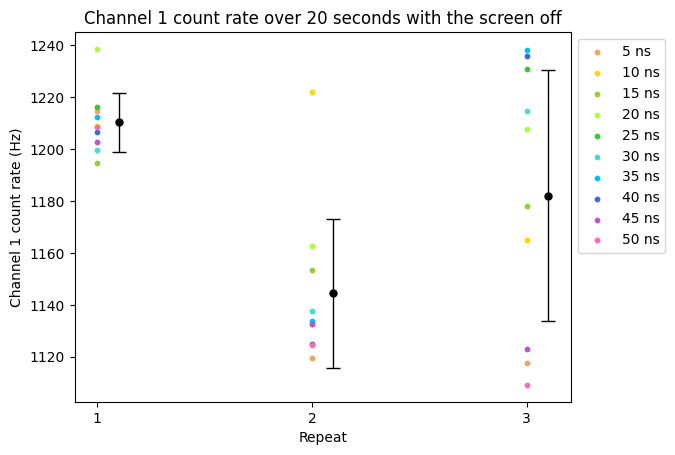

Average of the means: 1178.895 +- 15.586269598592242 Hz
Average stdev: 29.481017102826616 Hz


In [8]:
# Remove anomalies
new_screenoff_countdata_1 = screenoff_countdata_1[1:,1]
new_screenoff_countdata_2 = screenoff_countdata_2[1:,1]
new_screenoff_countdata_3 = screenoff_countdata_3[1:,1]

# Plot data
for i in range(10):
    plt.scatter(1, new_screenoff_countdata_1[i-1]/20, label = f"{ns_values[i+1]} ns", color=colors[i+1], s=10)
    plt.scatter(2, new_screenoff_countdata_2[i-1]/20, color=colors[i+1], s=10)
    plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=colors[i+1], s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(new_screenoff_countdata_1/20), np.mean(new_screenoff_countdata_2/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(new_screenoff_countdata_1/20), np.std(new_screenoff_countdata_2/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 1 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

To test this theory, lets graph the coincidence rates:

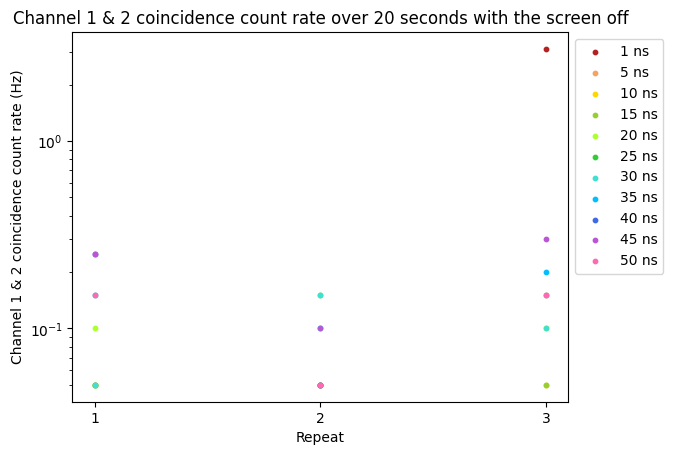

In [9]:
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,33]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenoff_countdata_2[i,33]/20, color=colors[i], s=10)
    plt.scatter(3, screenoff_countdata_3[i,33]/20, color=colors[i], s=10)
plt.title("Channel 1 & 2 coincidence count rate over 20 seconds with the screen off")
plt.ylabel("Channel 1 & 2 coincidence count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.semilogy()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

Note that the data points lie on each other because we have so little counts that its effectively discretised

Hmmm this doesn't really fit the previous idea. In fact we observe the opposite problem, the coincidence rate for 1ns seems to be quite high for only repeat 3. Perhaps I was wearing my watch the last time (though I don't recall very well), and the watch screen caused a consistent raised level comparable to that of the screen reflected off the black surface?

Moving on to channel 2:

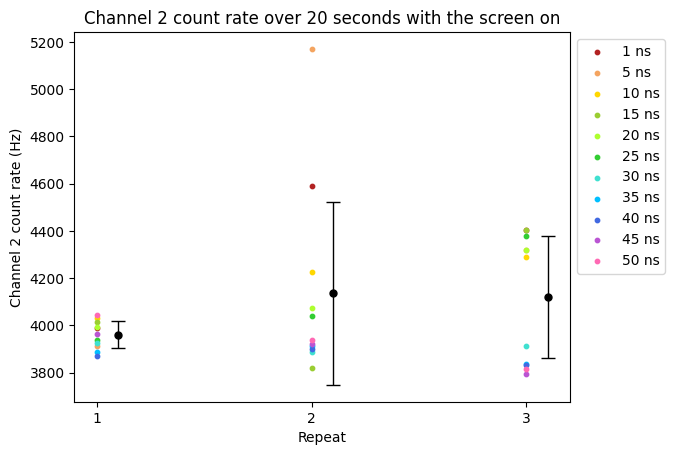

Average of the means: 4071.162121212121 +- 45.476482046712434 Hz
Average stdev: 234.2632681545302 Hz


In [10]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenon_countdata_1[i,2]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenon_countdata_2[i,2]/20, color=colors[i], s=10)
    plt.scatter(3, screenon_countdata_3[i,2]/20, color=colors[i], s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenon_countdata_1[:,2]/20), np.mean(screenon_countdata_2[:,2]/20), np.mean(screenon_countdata_3[:,2]/20)])
stdevs = np.array([np.std(screenon_countdata_1[:,2]/20), np.std(screenon_countdata_2[:,2]/20), np.std(screenon_countdata_3[:,2]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 2 count rate over 20 seconds with the screen on")
plt.ylabel("Channel 2 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

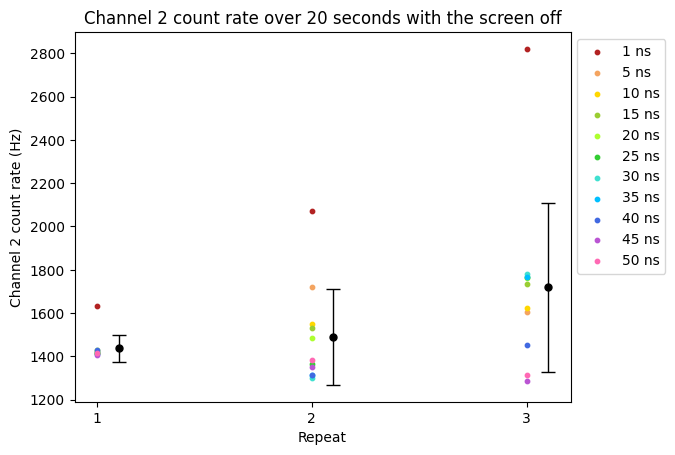

Average of the means: 1549.010606060606 +- 70.5340532913484 Hz
Average stdev: 224.24823044498763 Hz


In [11]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenoff_countdata_1[i,2]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenoff_countdata_2[i,2]/20, color=colors[i], s=10)
    plt.scatter(3, screenoff_countdata_3[i,2]/20, color=colors[i], s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenoff_countdata_1[:,2]/20), np.mean(screenoff_countdata_2[:,2]/20), np.mean(screenoff_countdata_3[:,2]/20)])
stdevs = np.array([np.std(screenoff_countdata_1[:,2]/20), np.std(screenoff_countdata_2[:,2]/20), np.std(screenoff_countdata_3[:,2]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 2 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 2 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

Ok this is really weird. I suspect that using my phone to time the data taking, or the brief time the computer screen was on caused the spike at 1ns, but it isn't showing up on the timestamp data. I think the counts and timestamp data are recorded differently: the timestamp data has a buffer which probably filled and reset within the 20 sec of exposure time which is why we don't see any spike near the beginning in the previous countrate-time graph. <br>
I'm just gonna assume that all screen-off 1ns data is anomalous and disregard it.

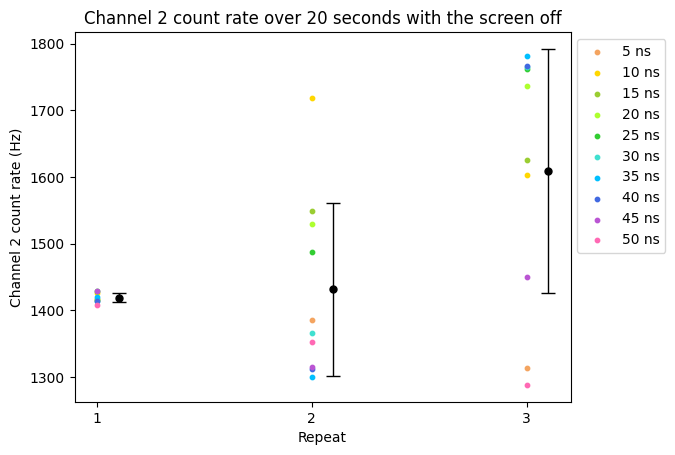

Average of the means: 1486.4383333333333 +- 50.19538858486087 Hz
Average stdev: 106.31355241960136 Hz


In [12]:
# Remove anomalies
new_screenoff_countdata_1 = screenoff_countdata_1[1:,2]
new_screenoff_countdata_2 = screenoff_countdata_2[1:,2]
new_screenoff_countdata_3 = screenoff_countdata_3[1:,2]

# Plot data
for i in range(10):
    plt.scatter(1, new_screenoff_countdata_1[i-1]/20, label = f"{ns_values[i+1]} ns", color=colors[i+1], s=10)
    plt.scatter(2, new_screenoff_countdata_2[i-1]/20, color=colors[i+1], s=10)
    plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=colors[i+1], s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(new_screenoff_countdata_1/20), np.mean(new_screenoff_countdata_2/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(new_screenoff_countdata_1/20), np.std(new_screenoff_countdata_2/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 2 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 2 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

On to channel 3 (with a cap on):

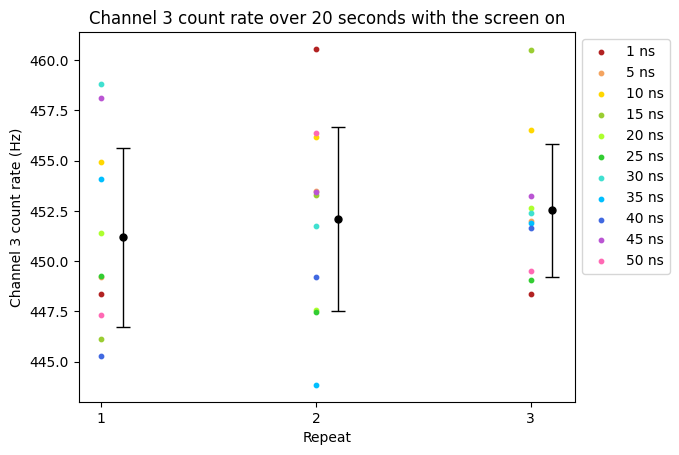

Average of the means: 451.9333333333334 +- 0.324343890477153 Hz
Average stdev: 4.112532546186248 Hz


In [13]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenon_countdata_1[i,3]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenon_countdata_2[i,3]/20, color=colors[i], s=10)
    plt.scatter(3, screenon_countdata_3[i,3]/20, color=colors[i], s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenon_countdata_1[:,3]/20), np.mean(screenon_countdata_2[:,3]/20), np.mean(screenon_countdata_3[:,3]/20)])
stdevs = np.array([np.std(screenon_countdata_1[:,3]/20), np.std(screenon_countdata_2[:,3]/20), np.std(screenon_countdata_3[:,3]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 3 count rate over 20 seconds with the screen on")
plt.ylabel("Channel 3 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

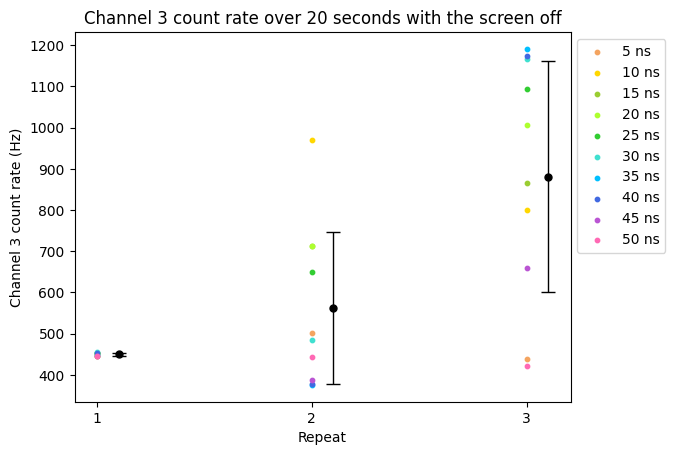

Average of the means: 630.8783333333332 +- 105.50900194173357 Hz
Average stdev: 156.40653717170116 Hz
Repeat 1 mean: 449.82, and stdev: 4.070700185471781


In [14]:
# Remove anomalies
new_screenoff_countdata_1 = screenoff_countdata_1[1:,3]
new_screenoff_countdata_2 = screenoff_countdata_2[1:,3]
new_screenoff_countdata_3 = screenoff_countdata_3[1:,3]

# Plot data
for i in range(10):
    plt.scatter(1, new_screenoff_countdata_1[i-1]/20, label = f"{ns_values[i+1]} ns", color=colors[i+1], s=10)
    plt.scatter(2, new_screenoff_countdata_2[i-1]/20, color=colors[i+1], s=10)
    plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=colors[i+1], s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(new_screenoff_countdata_1/20), np.mean(new_screenoff_countdata_2/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(new_screenoff_countdata_1/20), np.std(new_screenoff_countdata_2/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 3 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 3 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

print(f"Repeat 1 mean: {means[0]}, and stdev: {stdevs[0]}")

Onto channel 4 (should be similar to channel 3):

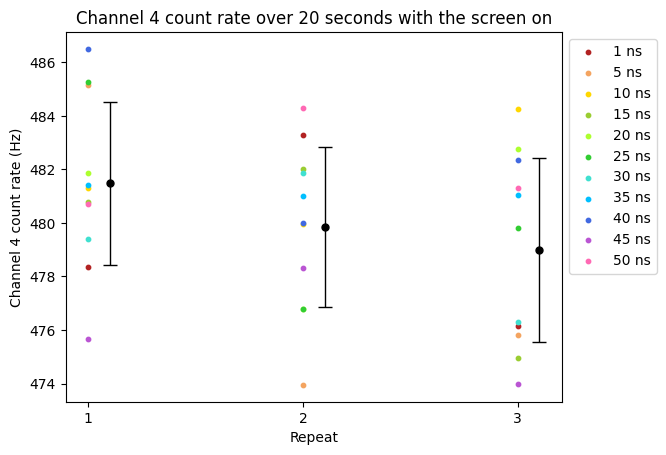

Average of the means: 480.09999999999997 +- 0.6018375595769231 Hz
Average stdev: 3.1546624685790037 Hz


In [15]:
# Plot repeats
for i in range(11):
    plt.scatter(1, screenon_countdata_1[i,4]/20, label = f"{ns_values[i]} ns", color=colors[i], s=10)
    plt.scatter(2, screenon_countdata_2[i,4]/20, color=colors[i], s=10)
    plt.scatter(3, screenon_countdata_3[i,4]/20, color=colors[i], s=10)

# Calculate means and stdevs of each repeat
means = np.array([np.mean(screenon_countdata_1[:,4]/20), np.mean(screenon_countdata_2[:,4]/20), np.mean(screenon_countdata_3[:,4]/20)])
stdevs = np.array([np.std(screenon_countdata_1[:,4]/20), np.std(screenon_countdata_2[:,4]/20), np.std(screenon_countdata_3[:,4]/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 4 count rate over 20 seconds with the screen on")
plt.ylabel("Channel 4 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

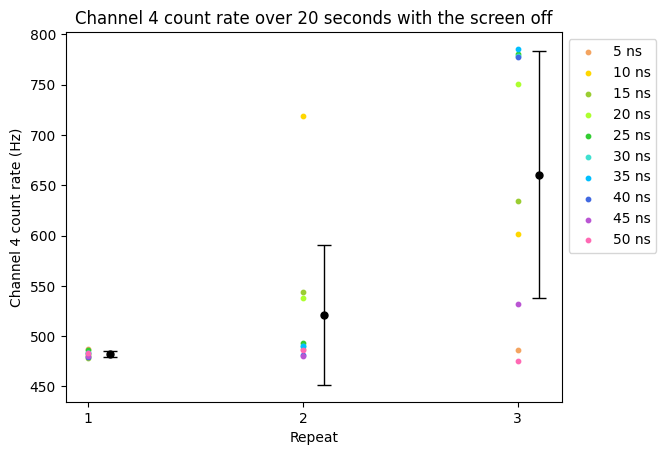

Average of the means: 554.5216666666666 +- 44.197634258793485 Hz
Average stdev: 65.00274411596081 Hz
Repeat 1 mean: 482.215, and stdev: 2.849039311768091


In [16]:
# Remove anomalies
new_screenoff_countdata_1 = screenoff_countdata_1[1:,4]
new_screenoff_countdata_2 = screenoff_countdata_2[1:,4]
new_screenoff_countdata_3 = screenoff_countdata_3[1:,4]

# Plot data
for i in range(10):
    plt.scatter(1, new_screenoff_countdata_1[i-1]/20, label = f"{ns_values[i+1]} ns", color=colors[i+1], s=10)
    plt.scatter(2, new_screenoff_countdata_2[i-1]/20, color=colors[i+1], s=10)
    plt.scatter(3, new_screenoff_countdata_3[i-1]/20, color=colors[i+1], s=10)


# Calculate means and stdevs of each repeat
means = np.array([np.mean(new_screenoff_countdata_1/20), np.mean(new_screenoff_countdata_2/20), np.mean(new_screenoff_countdata_3/20)])
stdevs = np.array([np.std(new_screenoff_countdata_1/20), np.std(new_screenoff_countdata_2/20), np.std(new_screenoff_countdata_3/20)])
plt.errorbar(1.1, means[0], stdevs[0], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(2.1, means[1], stdevs[1], color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.errorbar(3.1, means[2], stdevs[2], color="black", capsize=5, fmt="o", lw=1, markersize=5)

plt.title("Channel 4 count rate over 20 seconds with the screen off")
plt.ylabel("Channel 4 count rate (Hz)")
plt.xlabel("Repeat")
plt.xticks([1,2,3])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

print(f"Average of the means: {np.mean(means)} +- {np.std(means)/np.sqrt(3)} Hz")
print(f"Average stdev: {np.mean(stdevs)} Hz")

print(f"Repeat 1 mean: {means[0]}, and stdev: {stdevs[0]}")

Ok what is going on with the screen off datasets for channel 3 and 4 in the 2nd and 3rd repeats??????<br>
Maybe the caps on the sensors were removed when realigning or smth??<br>
They are very obviously wrong, so I will only care about repeat 1

Next, lets look at the coincidence rates over different windows:

Screen on:

TOTAL 1ns window counts:  3 84 16
TOTAL 5ns window counts:  2 28 5
TOTAL 10ns window counts:  10 6 11
TOTAL 15ns window counts:  21 4 24
TOTAL 20ns window counts:  18 20 28
TOTAL 25ns window counts:  22 24 43
TOTAL 30ns window counts:  31 35 18
TOTAL 35ns window counts:  38 54 36
TOTAL 40ns window counts:  31 55 42
TOTAL 45ns window counts:  46 42 43
TOTAL 50ns window counts:  65 45 46


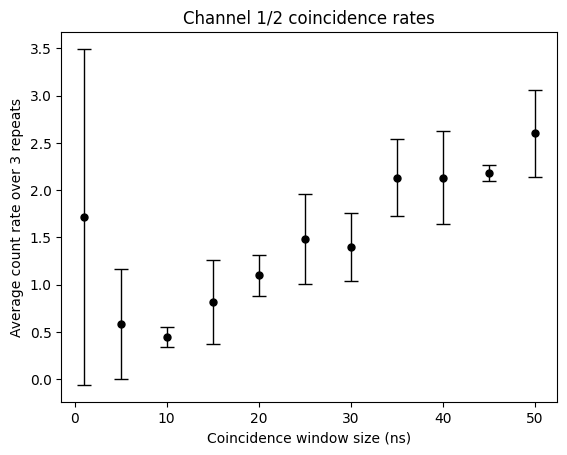

In [ ]:
# For each coincidence window
for i in range(11):
    print(f"TOTAL {ns_values[i]}ns window counts: ", *[screenon_countdata_1[i, 33],screenon_countdata_2[i, 33],screenon_countdata_3[i, 33]])
    # Calculate count rate
    mean = np.mean([screenon_countdata_1[i, 33],screenon_countdata_2[i, 33],screenon_countdata_3[i, 33]])/20
    stdev = np.std([screenon_countdata_1[i, 33],screenon_countdata_2[i, 33],screenon_countdata_3[i, 33]])/20
    plt.errorbar(ns_values[i], mean, stdev, color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.title("Channel 1/2 coincidence rates (screen on)")
plt.xlabel("Coincidence window size (ns)")
plt.ylabel("Average count rate over 3 repeats")
plt.show()

Screen off:

TOTAL 1ns window counts:  0 1 62
TOTAL 5ns window counts:  1 1 0
TOTAL 10ns window counts:  0 0 1
TOTAL 15ns window counts:  1 3 1
TOTAL 20ns window counts:  2 0 2
TOTAL 25ns window counts:  1 1 3
TOTAL 30ns window counts:  1 3 2
TOTAL 35ns window counts:  3 2 4
TOTAL 40ns window counts:  5 1 0
TOTAL 45ns window counts:  5 2 6
TOTAL 50ns window counts:  3 1 3


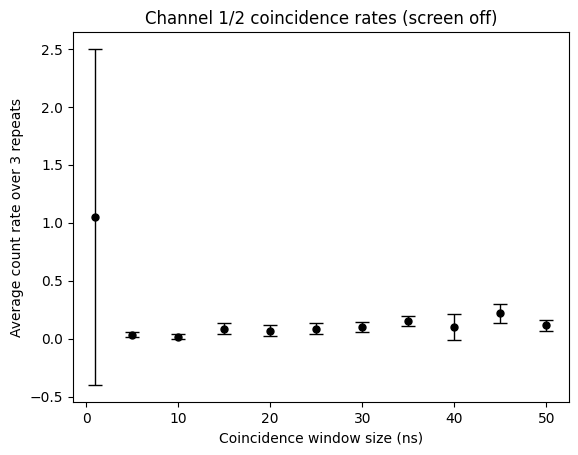

In [28]:
# For each coincidence window
for i in range(11):
    print(f"TOTAL {ns_values[i]}ns window counts: ", *[screenoff_countdata_1[i, 33],screenoff_countdata_2[i, 33],screenoff_countdata_3[i, 33]])
    # Calculate count rate
    mean = np.mean([screenoff_countdata_1[i, 33],screenoff_countdata_2[i, 33],screenoff_countdata_3[i, 33]])/20
    stdev = np.std([screenoff_countdata_1[i, 33],screenoff_countdata_2[i, 33],screenoff_countdata_3[i, 33]])/20
    plt.errorbar(ns_values[i], mean, stdev, color="black", capsize=5, fmt="o", lw=1, markersize=5)
plt.title("Channel 1/2 coincidence rates (screen off)")
plt.xlabel("Coincidence window size (ns)")
plt.ylabel("Average count rate over 3 repeats")
plt.show()

Again, some weirdness here, probably due to the phone/computer screen. I'll remove the obvious anomalies like the 84 in "TOTAL 1ns window counts:  3 84 16" and the 62 in "TOTAL 1ns window counts:  0 1 62":